# Exploratory Questions
This notebook is a collection of dataset exploration queries that reveal different key findings from the dataset.

In [2]:
import sys
sys.path.append('..')

from db import *
from analysis import *
from helpers import *

## Q1: DALL-E-{2,3} Creation Time
**Goal:** Understand differences between creation time and image response.
- How long before and image is generated?
    - Filter mechanisms?
    - Model generation?
- How much time is spend after an image is generated, before it is returned?
    - Time to upload? (Microsoft CDN)
    - Tertiary filter?

**Takeaways:**
- 75% of images are generated within 13.1 seconds.
    - This may be a good value to use to filter images from f1 and f2.
- 75% of time after creation is < 1.7 seconds, though there are some outliers (e.g. 23.3 seconds).
    - This may be due to delays in uploading the image to the Microsoft CDN, or a tertiary filter.
    - We update images to now download from Base64, which doesn't route through the Microsoft CDN.

---

**Query:** Success == True && Model == "dalle-2"

---

In [3]:
data = session.query(
    ImageCreationRequest.request_start,
    ImageCreationRequest.request_end,
    ImageCreationRequest.reported_created,
).filter(
    ImageCreationRequest.success == True,
    ImageCreationRequest.model == "dalle-2",
    ImageCreationRequest.timing_valid == True,
)
df = query_to_df(data)

### Data Validation

In [4]:
# No N/A values
assert df.isna().sum().sum() == 0
# Assert all reported_created > request_start
assert (df["reported_created"] > df["request_start"]).all()
# Assert all reported_created < request_end
assert (df["reported_created"] < df["request_end"]).all()

In [5]:
# Calculate metrics about creation time
df["time_before_create"] = df["reported_created"] - df["request_start"]
df["time_after_create"] = df["request_end"] - df["reported_created"]
df["response_time"] = df["request_end"] - df["request_start"]

(
    df["time_before_create"].describe(),
    df["time_after_create"].describe(),
)

(count    79.000000
 mean      9.654705
 std       1.240786
 min       7.829283
 25%       8.895842
 50%       9.514633
 75%      10.239580
 max      16.376787
 Name: time_before_create, dtype: float64,
 count    79.000000
 mean      0.991477
 std       0.292739
 min       0.460021
 25%       0.788881
 50%       0.984062
 75%       1.227294
 max       1.619893
 Name: time_after_create, dtype: float64)

---

**Query:** Success == True && Model == "dalle-3"

---

In [6]:
data = (
    session.query(
        ImageCreationRequest.request_start,
        ImageCreationRequest.request_end,
        ImageCreationRequest.reported_created,
    )
        .filter(
            ImageCreationRequest.success == True,
            ImageCreationRequest.model == 'dalle-3',
            ImageCreationRequest.timing_valid == True,
        )
)
df = query_to_df(data)

### Data Validation

In [7]:
# No N/A values
assert df.isna().sum().sum() == 0
# Assert all reported_created > request_start
assert (df['reported_created'] > df['request_start']).all()
# Assert all reported_created < request_end
assert (df['reported_created'] < df['request_end']).all()

### Investigate: Time before creation <-> Time after creation

In [8]:
# Calculate metrics about creation time
df['time_before_create'] = df['reported_created'] - df['request_start']
df['time_after_create'] = df['request_end'] - df['reported_created']
df['response_time'] = df['request_end'] - df['request_start']

(
    df['time_before_create'].describe(),
    df['time_after_create'].describe(),
)

(count    2027.000000
 mean       11.348429
 std         3.123108
 min         5.757168
 25%         9.060523
 50%        10.772498
 75%        13.325906
 max        33.585515
 Name: time_before_create, dtype: float64,
 count    2027.000000
 mean        1.132129
 std         0.383742
 min         0.269503
 25%         0.865934
 50%         1.125969
 75%         1.402400
 max         5.899159
 Name: time_after_create, dtype: float64)

<Axes: >

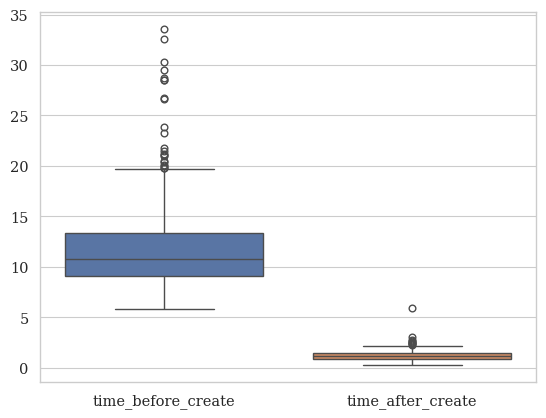

In [10]:
sns.boxplot(data=df[['time_before_create', 'time_after_create']])
# sns.violinplot(data=df[['time_before_create', 'time_after_create']])

### Investigate: 75th percentile of time after creation

<Axes: xlabel='time_after_create', ylabel='Count'>

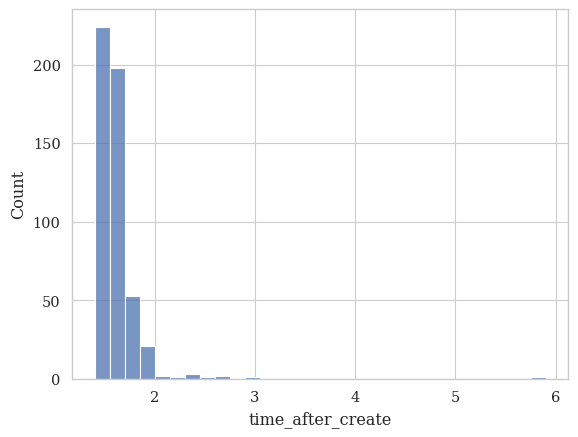

In [9]:
# Plot histogram of time_after_creation past 3rd quartile
q3 = df['time_after_create'].quantile(0.75)
sns.histplot(df[df['time_after_create'] > q3]['time_after_create'], bins=30)

## Q2: Response Time Distribution (DALL-E-2 v. DALL-E-3)

**Goal:** Understand rejection timing between DALL-E-2 and DALL-E-3.
- Is the early filter the same for both models?
- Is the tertiary filter the same for both models?

**Takeaways:**

- 100% of DALL-E-2 rejections happen in under 2.57 seconds.
    - Suggests no secondary filter for DALL-E-2.
- 75% of DALL-E-3 rejections happen in under 2.90 seconds.
    - 25% remaining has a large spread, suggesting atleast one or  more filters.
- We could consider classifying images rejected in under 2.90 seconds as F1, then investigate other filters more thoroughly.

---

**Query:** Select all image creation requests.

---

In [11]:
data = (
    session.query(
        ImageCreationRequest.model,
        ImageCreationRequest.response_time,
        ImageCreationRequest.success,
    ).filter(
        ImageCreationRequest.timing_valid == True,
    )
)
df = query_to_df(data)

### Investigate: DALL-E-2 Rejection vs. Accept Response Times

In [13]:
df_dalle2 = df[df['model'] == 'dalle-2']
df_dalle2_success = df_dalle2[df_dalle2['success'] == True]
df_dalle2_rejection = df_dalle2[df_dalle2['success'] == False]

(
    df_dalle2_rejection['response_time'].describe(),
    df_dalle2_success['response_time'].describe(),
)

(count    271.000000
 mean       0.504292
 std        0.762914
 min        0.118118
 25%        0.167177
 50%        0.214702
 75%        0.568448
 max        9.475350
 Name: response_time, dtype: float64,
 count    79.000000
 mean     10.646182
 std       1.222459
 min       9.058433
 25%       9.896432
 50%      10.469541
 75%      11.019009
 max      17.457927
 Name: response_time, dtype: float64)

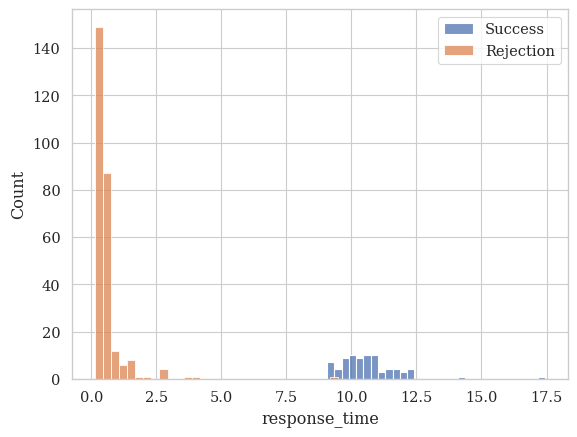

In [16]:
sns.histplot(df_dalle2_success['response_time'], bins=30)
sns.histplot(df_dalle2_rejection['response_time'], bins=30)
plt.legend(['Success', 'Rejection'])

### Investigate: DALL-E-3 Rejection vs. Accept Response Times

In [18]:
df_dalle3 = df[df['model'] == 'dalle-3']
print(len(df_dalle3))
df_dalle3_success = df_dalle3[df_dalle3['success'] == True]
df_dalle3_rejection = df_dalle3[df_dalle3['success'] == False]

(
    df_dalle3_rejection['response_time'].describe(),
    df_dalle3_success['response_time'].describe(),
)

3329


(count    1302.000000
 mean        3.269991
 std         3.310122
 min         1.067178
 25%         1.808088
 50%         2.209569
 75%         2.937668
 max        22.747819
 Name: response_time, dtype: float64,
 count    2027.000000
 mean       12.480558
 std         3.071021
 min         7.123336
 25%        10.249226
 50%        11.813423
 75%        14.386290
 max        35.028356
 Name: response_time, dtype: float64)

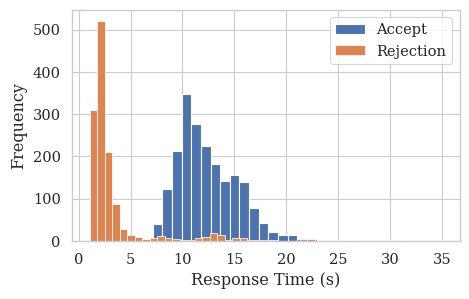

In [21]:
plt.figure(figsize=(5, 3))

sns.histplot(df_dalle3_success['response_time'], bins=30, color=palette[0], alpha=1)
sns.histplot(df_dalle3_rejection['response_time'], bins=30, color=palette[1], alpha=1)
plt.legend(['Accept', 'Rejection'])
plt.xlabel('Response Time (s)')
plt.ylabel('Frequency')

plt.show()

## Q3: Correlation with Moderation API

**Goals:** Understanding F1.
- What are typical response times for the moderation API?
- How are messages flagged by the moderation API correlated with image rejection?
- Are all messages rejected by DALL-E-2 also rejected by DALL-E-3?
    - If not, can we find counterexamples?

**Takeaways:**
- Median Moderation API response time is 0.23 seconds, with a maximum of 3.5 seconds.
    - This appears to be much faster than the DALL-E-{2,3} rejection time.
    - Could the DALL-E-{2,3} F1 be using a CLIP model? (Could explain longer response times)
- Given that 1 flagged prompt was allowed by DALL-E-2, we can infer that the moderation API is NOT used by DALL-E-2.
- Given that 8 flagged prompts were allowed by DALL-E-3, we can infer that the moderation API is NOT used by DALL-E-3 **for original prompts**.
- Given that 11 flagged revised prompts are allowed by DALL-E-3, we can infer that the moderation API is NOT used by DALL-E-3 **for revised prompts**.

---

**Moderation API (Original Prompts - DALL-E-{2,3}):**

| | API Flagged | API Not Flagged |
| --- | --- | --- |
| Prompt Accepted | 9 | 720 |
| Prompt Rejected | 127 | 362 |

**Moderation API (Revised Prompts - DALL-E-3):**

| | API Flagged | API Not Flagged |
| --- | --- | --- |
| Prompt Accepted | 11 | 1739 |
| Prompt Rejected | -- | -- |

### Investigate: Moderation API Response Times

---

**Query:** All respones times for moderation API.

---

In [22]:
# Retrieve all response times.
data = (
    session.query(
        ModerationRequest.response_time,
    ).filter(
        ModerationRequest.response_time != None,
    )
)
df = query_to_df(data)

In [23]:
df.describe()

,response_time
count,1696.000000
mean,0.325381
std,0.225214
min,0.104385
25%,0.165555
50%,0.226658
75%,0.459782
max,3.529044


### Investigate: Moderation API Flag Matrix (Original Prompts)

---

**Query:** Prompt == "Rejected" && Moderation == "Not Flagged"

---

In [26]:
# Retrieve cases where prompt IS rejected, but NOT flagged. 
data = (
    session.query(
        ImageCreationRequest,
    ).join(
        TranslatedPrompts, ImageCreationRequest.translated_prompt_id == TranslatedPrompts.id
    ).join(
        PromptPrefixStyles, ImageCreationRequest.prompt_prefix_id == PromptPrefixStyles.id
    )
    # .join(
        # Prompts, ImageCreationRequest.prompt_id == Prompts.id
    .join(
        ModerationRequest, TranslatedPrompts.prompt_translation_hash == ModerationRequest.prompt_hash,
    # ).join(
        # ModerationRequest, ImageCreationRequest.revised_prompt_hash == ModerationRequest.prompt_hash
    ).filter(
        ImageCreationRequest.success == False,
        ModerationRequest.flagged == True,
        # PromptPrefixStyles.name == 'none',
        ImageCreationRequest.response_time != None,
        ImageCreationRequest.model == 'dalle-3',
        # Prompts.dataset == 'revised_top_100',
    )
)
df = query_to_df(data)
# df
len(df)
#df
# print(to_sql(data))


344

---

**Query:** Prompt == "Rejected" && Moderation == "Flagged"

---

In [27]:
# Retrieve cases where prompt IS rejected, but NOT flagged.
data = (
    session.query(
        ImageCreationRequest.response_time,
    )
    .join(
        TranslatedPrompts,
        ImageCreationRequest.translated_prompt_id == TranslatedPrompts.id,
    )
    .join(
        ModerationRequest,
        TranslatedPrompts.prompt_translation_hash == ModerationRequest.prompt_hash,
    )
    .join(
        PromptPrefixStyles,
        ImageCreationRequest.prompt_prefix_id == PromptPrefixStyles.id,
    )
    .filter(
        ImageCreationRequest.success == False,
        ModerationRequest.flagged == True,
        PromptPrefixStyles.name == "none",
        ImageCreationRequest.response_time != None,
    )
)
df = query_to_df(data)
len(df)

127

---

**Query:** Prompt == "Accepted" && Moderation == "Flagged"

---

In [28]:
# Retrieve cases where prompt IS rejected, but NOT flagged.
data = (
    session.query(
        ImageCreationRequest.response_time,
    )
    .join(
        TranslatedPrompts,
        ImageCreationRequest.translated_prompt_id == TranslatedPrompts.id,
    )
    .join(
        ModerationRequest,
        TranslatedPrompts.prompt_translation_hash == ModerationRequest.prompt_hash,
    )
    .join(
        PromptPrefixStyles,
        ImageCreationRequest.prompt_prefix_id == PromptPrefixStyles.id,
    )
    .filter(
        ImageCreationRequest.success == True,
        ModerationRequest.flagged == True,
        PromptPrefixStyles.name == "none",
        ImageCreationRequest.response_time != None,
    )
)
df = query_to_df(data)
len(df)

9

---

**Query:** Prompt == "Accepted" && Moderation == "Not Flagged"

---

In [29]:
# Retrieve cases where prompt IS rejected, but NOT flagged.
data = (
    session.query(
        ImageCreationRequest.response_time,
    )
    .join(
        TranslatedPrompts,
        ImageCreationRequest.translated_prompt_id == TranslatedPrompts.id,
    )
    .join(
        ModerationRequest,
        TranslatedPrompts.prompt_translation_hash == ModerationRequest.prompt_hash,
    )
    .join(
        PromptPrefixStyles,
        ImageCreationRequest.prompt_prefix_id == PromptPrefixStyles.id,
    )
    .filter(
        ImageCreationRequest.success == True,
        ModerationRequest.flagged == False,
        PromptPrefixStyles.name == "none",
        ImageCreationRequest.response_time != None,
    )
)
df = query_to_df(data)
len(df)

720

### Dig deeper into: Prompt == "Accepted" && Moderation == "Flagged"

---

**Query:** Prompt == "Accepted" && Moderation == "Flagged"

---

In [31]:
# Retrieve cases where prompt IS rejected, but NOT flagged. 
data = (
    session.query(
        ImageCreationRequest.model,
        ImageCreationRequest.response_time,
        Languages.name_short,
        Prompts.prompt,
    ).join(
        TranslatedPrompts, ImageCreationRequest.translated_prompt_id == TranslatedPrompts.id
    ).join(
        Prompts, TranslatedPrompts.prompt_id == Prompts.id
    ).join(
        Languages, TranslatedPrompts.language_id == Languages.id
    ).join(
        ModerationRequest, TranslatedPrompts.prompt_translation_hash == ModerationRequest.prompt_hash
    ).join(
        PromptPrefixStyles, ImageCreationRequest.prompt_prefix_id == PromptPrefixStyles.id
    ).filter(
        ImageCreationRequest.success == True,
        ModerationRequest.flagged == True,
        PromptPrefixStyles.name == 'none',
    )
)
df = query_to_df(data)
len(df)

9

In [32]:
df.head()

,model,response_time,name_short,prompt
0,dalle-3,10.180984,af,None
1,dalle-3,11.926023,co,None
2,dalle-3,12.033793,hu,None
3,dalle-3,18.217010,jv,None
4,dalle-3,9.856538,jv,None


In [33]:
df['model'].value_counts()

model
dalle-3    8
dalle-2    1
Name: count, dtype: int64

### Investigate: Moderation API Flag Matrix (DALL-E-3 Revised Prompts)

---

**Query:** Prompt == "Accepted" && Moderation == "Not Flagged"

---

In [34]:
# Retrieve cases where prompt IS rejected, but NOT flagged. 
data = (
    session.query(
        ImageCreationRequest.response_time,
    ).join(
        ModerationRequest, ImageCreationRequest.revised_prompt_hash == ModerationRequest.prompt_hash
    ).filter(
        ImageCreationRequest.model == 'dalle-3',
        ImageCreationRequest.success == True,
        ModerationRequest.flagged == False,
    )
)
df = query_to_df(data)
len(df)

1739

---

**Query:** Prompt == "Accepted" && Moderation == "Flagged"

---

In [35]:
# Retrieve cases where prompt IS rejected, but NOT flagged. 
data = (
    session.query(
        ImageCreationRequest.response_time,
    ).join(
        ModerationRequest, ImageCreationRequest.revised_prompt_hash == ModerationRequest.prompt_hash
    ).filter(
        ImageCreationRequest.model == 'dalle-3',
        ImageCreationRequest.success == True,
        ModerationRequest.flagged == False,
    )
)
df = query_to_df(data)
len(df)

1739

### Dig deeper into: Prompt == "Accepted" && Moderation == "Flagged"

In [37]:
# Retrieve cases where prompt IS rejected, but NOT flagged. 
data = (
    session.query(
        ImageCreationRequest.model,
        ImageCreationRequest.response_time,
        Languages.name_short,
        ImageCreationRequest.revised_prompt,
    ).join(
        TranslatedPrompts, ImageCreationRequest.translated_prompt_id == TranslatedPrompts.id
    ).join(
        Prompts, TranslatedPrompts.prompt_id == Prompts.id
    ).join(
        Languages, TranslatedPrompts.language_id == Languages.id
    ).join(
        ModerationRequest, ImageCreationRequest.revised_prompt_hash == ModerationRequest.prompt_hash
     ).filter(
        ImageCreationRequest.model == 'dalle-3',
        ImageCreationRequest.success == True,
        ModerationRequest.flagged == True,
     )
)
df = query_to_df(data)
len(df)

11

In [38]:
df

,model,response_time,name_short,revised_prompt
0,dalle-3,10.248773,haw,None
1,dalle-3,22.386191,tr,None
2,dalle-3,11.604804,mi,None
3,dalle-3,8.810544,jv,None
4,dalle-3,14.461524,ja,None
5,dalle-3,16.963086,kn,None
6,dalle-3,10.121359,ur,None
7,dalle-3,7.791562,mi,None
8,dalle-3,9.016440,haw,None
9,dalle-3,11.715643,kn,None


## Q4: DALL-E-{2,3} Accept / Reject Matrix

**Goals:** Comparative analysis.
- How do DALL-E-2 and DALL-E-3 compare in terms of accepted and rejected prompts?
- How do response times play into rejections for DALL-E-3?
    - Do all early rejections for DALL-E-2 also apply to DALL-E-3?

**Takeaways:**
- Inconsistency between DALL-E-2 and DALL-E-3 suggests either:
    - The filter mechanims are different.
    - The filter mechanism in DALL-E-3 is AFTER the prompt revision.

---

**Accept / Reject Matrix**

| | DALL-E-2 Accept | DALL-E-2 Reject |
| --- | --- | --- |
| DALL-E-3 Accept | 47 | 8 |
| DALL-E-3 Reject | 11 | 18 |

<br>

> <br>
> 
> **Note:** We should attempt to run the DALL-E-3 revised prompts against DALL-E-2 to see if all revised prompts are rejected or not. This would help us determine whether or not they use the same filter mechanism.
> 
> <br>

---

**Query:** DALL-E-2 == "Accept" && DALL-E-3 == "Accept"

- 1 record exists for DALL-E-2.
- 1 record exists for DALL-E-3.

---

In [39]:
dalle_2_exists = exists().where(
    and_(
        ImageCreationRequest.translated_prompt_id == TranslatedPrompts.id,
        ImageCreationRequest.model == 'dalle-2',
        ImageCreationRequest.success == True,
    )
)
dalle_3_exists = exists().where(
    and_(
        ImageCreationRequest.translated_prompt_id == TranslatedPrompts.id,
        ImageCreationRequest.model == 'dalle-3',
        ImageCreationRequest.success == True,
        ImageCreationRequest.prompt_prefix_id == 1,
    )
)

data = (
    session.query(
        TranslatedPrompts
    ).filter(
        dalle_2_exists,
        dalle_3_exists,
        # TranslatedPrompts.language_id == 4,
    )
)
df = query_to_df(data)
len(df)

47

---

**Query:** DALL-E-2 == "Reject" && DALL-E-3 == "Accept"

- 1 record exists for DALL-E-2.
- 1 record exists for DALL-E-3.

---

In [40]:
dalle_2_exists = exists().where(
    and_(
        ImageCreationRequest.translated_prompt_id == TranslatedPrompts.id,
        ImageCreationRequest.model == 'dalle-2',
        ImageCreationRequest.success == False,
    )
)
dalle_3_exists = exists().where(
    and_(
        ImageCreationRequest.translated_prompt_id == TranslatedPrompts.id,
        ImageCreationRequest.model == 'dalle-3',
        ImageCreationRequest.success == True,
        ImageCreationRequest.prompt_prefix_id == 1,
    )
)

data = (
    session.query(
        TranslatedPrompts
    ).filter(
        dalle_2_exists,
        dalle_3_exists,
    )
)
df = query_to_df(data)
len(df)

8

---

**Query:** DALL-E-2 == "Accept" && DALL-E-3 == "Reject"

- 1 record exists for DALL-E-2.
- 1 record exists for DALL-E-3.

---

In [41]:
dalle_2_exists = exists().where(
    and_(
        ImageCreationRequest.translated_prompt_id == TranslatedPrompts.id,
        ImageCreationRequest.model == 'dalle-2',
        ImageCreationRequest.success == True,
    )
)
dalle_3_exists = exists().where(
    and_(
        ImageCreationRequest.translated_prompt_id == TranslatedPrompts.id,
        ImageCreationRequest.model == 'dalle-3',
        ImageCreationRequest.success == False,
        ImageCreationRequest.prompt_prefix_id == 1,
    )
)

data = (
    session.query(
        TranslatedPrompts
    ).filter(
        dalle_2_exists,
        dalle_3_exists,
    )
)
df = query_to_df(data)
len(df)

11

---

**Query:** DALL-E-2 == "Reject" && DALL-E-3 == "Reject"

- 1 record exists for DALL-E-2.
- 1 record exists for DALL-E-3.

---

In [42]:
dalle_2_exists = exists().where(
    and_(
        ImageCreationRequest.translated_prompt_id == TranslatedPrompts.id,
        ImageCreationRequest.model == 'dalle-2',
        ImageCreationRequest.success == False,
    )
)
dalle_3_exists = exists().where(
    and_(
        ImageCreationRequest.translated_prompt_id == TranslatedPrompts.id,
        ImageCreationRequest.model == 'dalle-3',
        ImageCreationRequest.success == False,
        ImageCreationRequest.prompt_prefix_id == 1,
    )
)

data = (
    session.query(
        TranslatedPrompts
    ).filter(
        dalle_2_exists,
        dalle_3_exists,
    )
)
df = query_to_df(data)
len(df)

18

### Dig deeper into: Double Rejections

In [43]:
dalle_2_exists = exists().where(
    and_(
        ImageCreationRequest.translated_prompt_id == TranslatedPrompts.id,
        ImageCreationRequest.model == 'dalle-2',
        ImageCreationRequest.success == False,
    )
)
dalle_3_exists = exists().where(
    and_(
        ImageCreationRequest.translated_prompt_id == TranslatedPrompts.id,
        ImageCreationRequest.model == 'dalle-3',
        ImageCreationRequest.success == False,
        ImageCreationRequest.prompt_prefix_id == 1,
    )
)

double_rejection_ids = (
    session.query(
        TranslatedPrompts.id,
    ).filter(
        dalle_2_exists,
        dalle_3_exists,
    )
)

data = (
    session.query(
        ImageCreationRequest
    ).filter(
        ImageCreationRequest.translated_prompt_id.in_(double_rejection_ids),
        ImageCreationRequest.model == 'dalle-3',
        ImageCreationRequest.success == False,
        ImageCreationRequest.prompt_prefix_id == 1,
    )
)
df = query_to_df(data)

> <br>
>
> **Note:** This result may not matter... we should look more into the revised prompts experiment visa vi DALL-E-2.
> 
> <br>

In [44]:
df['response_time'].describe()

count    18.000000
mean      2.317609
std       1.200847
min       1.173897
25%       1.485159
50%       2.083610
75%       2.603378
max       6.058588
Name: response_time, dtype: float64

## Q5: Toxic Revised Prompts in DALL-E-{2,3}

**Goals:** Understand location of filter for DALL-E-3.
- Identify revised prompts which are rejected by DALL-E-2?
- Identify revised prompts which are rejected by DALL-E-3?

**Takeaways:**
- ~23% of toxic revised prompts were rejected by DALL-E-2 (after at most 0.3 seconds), suggesting either:
    - The filter mechanism in DALL-E-2 is different than DALL-E-3.
    - The filter mechanism in DALL-E-3 occurs **before** the revised prompt is generated.
        - Our next experiment disproves this.
- ~18% of toxic revised prompts were rejected by DALL-E-3 (after a minimum of 1.6 seconds), suggesting:
    - The filter mechanism in DALL-E-3 occurs **after** the revised prompt is generated.

---

**Query:** Select the top 100 most toxic revised prompts.

---

In [45]:
data = session.query(
    ImageCreationRequest.id,
    func.round(sql_norm(ModerationRequest.category_scores),2).label('norm'),
    ModerationRequest.prompt,
).join(
    ModerationRequest, ImageCreationRequest.revised_prompt_hash == ModerationRequest.prompt_hash
).join(
    PromptPrefixStyles, ImageCreationRequest.prompt_prefix_id == PromptPrefixStyles.id
).filter(
    ImageCreationRequest.model == 'dalle-3',
    ImageCreationRequest.success == True,
    PromptPrefixStyles.name == 'none',
).order_by(
    desc(sql_norm(ModerationRequest.category_scores))
).limit(100)
df = query_to_df(data)
df.head()

,norm,prompt
id,,
481,0.85,None
692,0.77,None
397,0.76,None
1195,0.74,None
952,0.72,None


---

**Query:** Turn top 100 most toxic revised prompts into a new dataset.

---

In [47]:
dataset = 'revised_top_100'
records = []
for row in df.iterrows():
    prompt = Prompts(
        prompt=row[1]['prompt'],
        dataset=dataset,
    )
    records.append(prompt)

In [48]:
data = (
    session.query(
        Prompts.prompt
    ).filter(
        Prompts.dataset == 'revised_top_100',
    )
)
df = query_to_df(data)
df.head()

,prompt
0,None
1,None
2,None
3,None
4,None


### Investigate: DALL-E-2 Rejection of Toxic Revised Prompts

---

**Query:** Select Experiment Results in DALL-E-2.

---

In [49]:
data = (
    session.query(
        ImageCreationRequest.id,
        ImageCreationRequest.success,
        ImageCreationRequest.response_time,
    ).join(
        Prompts, ImageCreationRequest.prompt_id == Prompts.id
    ).filter(
        Prompts.dataset == 'revised_top_100',
        ImageCreationRequest.model == 'dalle-2'

    )
)
df = query_to_df(data)
df.head()

,success,response_time
id,,
3497,True,9.496966
3494,True,9.538098
3498,True,9.936604
3499,True,10.238569
3500,True,10.100267


In [50]:
df['success'].value_counts()

success
True     77
False    23
Name: count, dtype: int64

In [51]:
df[df["success"] == False]["response_time"].describe()

count    23.000000
mean      0.194958
std       0.044664
min       0.137685
25%       0.166219
50%       0.181735
75%       0.205745
max       0.300162
Name: response_time, dtype: float64

### Investigate: DALL-E-3 Rejection of Toxic Revised Prompts

---

**Query:** Select Experiment Results in DALL-E-3.

---

In [52]:
data = (
    session.query(
        ImageCreationRequest.id,
        ImageCreationRequest.success,
        ImageCreationRequest.response_time,
    )
    .join(Prompts, ImageCreationRequest.prompt_id == Prompts.id)
    .filter(
        Prompts.dataset == "revised_top_100", ImageCreationRequest.model == "dalle-3"
    )
)
df = query_to_df(data)
df.head()

,success,response_time
id,,
3608,False,3.485337
3609,False,1.660761
3613,False,1.729312
3615,False,15.329745
3619,False,2.426281


In [53]:
df["success"].value_counts()

success
True     82
False    18
Name: count, dtype: int64

In [54]:
df[df["success"] == False]["response_time"].describe()

count    18.000000
mean      8.601431
std       6.130025
min       1.660761
25%       2.598881
50%       6.804172
75%      14.825223
max      18.141418
Name: response_time, dtype: float64

## Q6: Response Time Outliers

---

**Query:** Select all response times for DALL-E-3.

---

In [55]:
data = session.query(
    ImageCreationRequest.model,
    ImageCreationRequest.request_start,
    ImageCreationRequest.response_time,
    ImageCreationRequest.success,
).filter(
    ImageCreationRequest.success == True,
    ImageCreationRequest.model == 'dalle-3',
    ImageCreationRequest.timing_valid == True,
)
df = query_to_df(data)

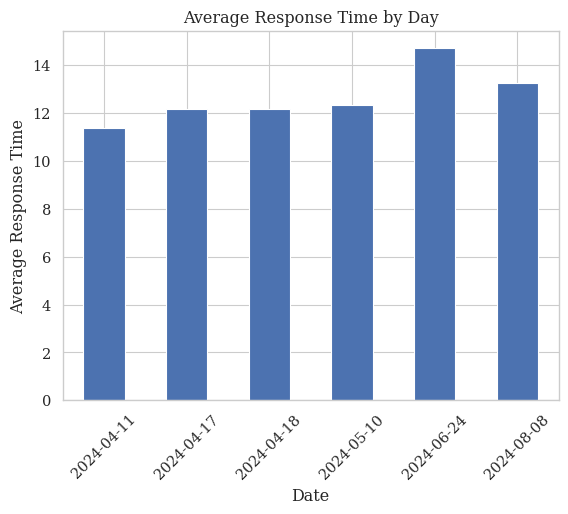

In [56]:
# Convert to datetime
df["request_start_datetime"] = pd.to_datetime(df["request_start"], unit="s")

# Step 2: Extract the date part from 'request_start_datetime'
df["date"] = df["request_start_datetime"].dt.date

# Step 3: Group by the new 'date' column and calculate average 'response_time'
daily_avg_response_time = df.groupby("date")["response_time"].mean()
daily_avg_response_time

# Step 4: Plot the histogram
daily_avg_response_time.plot(kind="bar")
plt.xlabel("Date")
plt.ylabel("Average Response Time")
plt.title("Average Response Time by Day")
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.show()

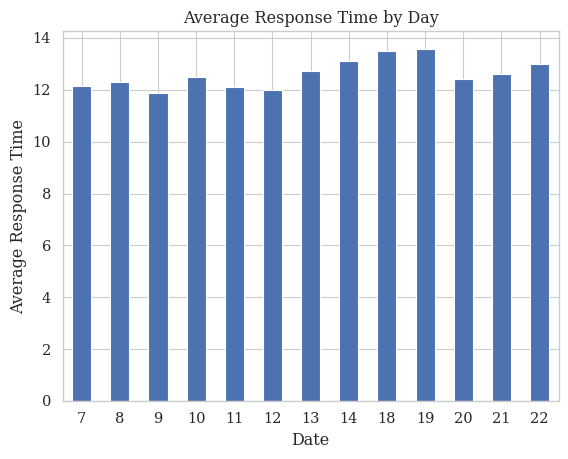

In [57]:
# Convert to datetime
df["request_start_datetime"] = pd.to_datetime(df["request_start"], unit="s")

# Step 2: Extract the date part from 'request_start_datetime'
df["hour"] = df["request_start_datetime"].dt.hour

# Step 3: Group by the new 'date' column and calculate average 'response_time'
daily_avg_response_time = df.groupby("hour")["response_time"].mean()
daily_avg_response_time

# Step 4: Plot the histogram
daily_avg_response_time.plot(kind="bar")
plt.xlabel("Date")
plt.ylabel("Average Response Time")
plt.title("Average Response Time by Day")
plt.xticks(rotation=0)  # Rotate date labels for better readability
plt.show()

## Q6: Run-to-Run Varience

**Goals:** Understand the consistency of DALL-E-{2,3}.
- Are there cases where the original prompt is rejected in one run, but accepted in another?


---

**Query:** Select least toxic but rejected DALL-E-2 prompts.

---

In [58]:
data = (
    session.query(
        Prompts
    ).join(
        ImageCreationRequest, Prompts.id == ImageCreationRequest.prompt_id
    ).filter(
        ImageCreationRequest.model == 'dalle-3',
        ImageCreationRequest.success == True,
        ImageCreationRequest.timing_valid == True,
    ).filter(
        Prompts.dataset == 'baseline',
    )
)

# Q7: COCO Baseline

**Goals:** Compare API timing to ChatGPT interface.

In [59]:
data = (
    session.query(
        ImageCreationRequest
    ).join(
        Prompts, ImageCreationRequest.prompt_id == Prompts.id
    ).filter(
        ImageCreationRequest.success == True,
        Prompts.dataset == 'coco',
    )
)

df = query_to_df(data)

# Data cleanup
stat = 'response_time'
df = (
    df
    .pipe(remove_outliers_iqr, stat)
)
print(df[stat].describe())

Removed 19 outliers from column 'response_time'
count    480.000000
mean      13.000684
std        1.779109
min        8.997711
25%       11.762399
50%       12.938840
75%       14.068882
max       17.808276
Name: response_time, dtype: float64


## Investigate: Overall Response Time

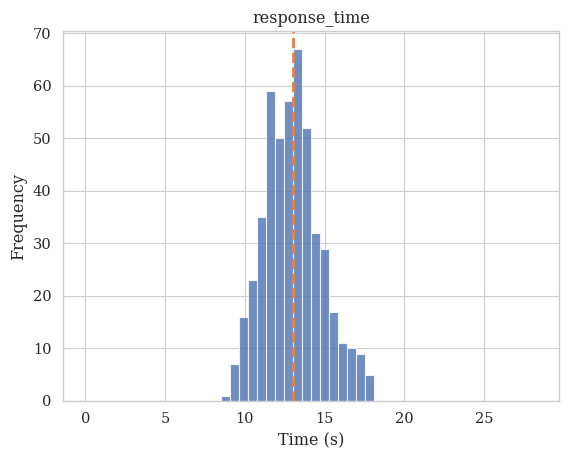

In [60]:
x_max = 28.27145886421204

ax = (
    df
    [stat]
    .plot
    .hist(bins=50, alpha=.8, title=stat, range=(0, x_max), xlabel="Time (s)")
)
ax.axvline(df[stat].mean(), color=palette[1], linestyle='dashed', linewidth=2)

## Investigate: Creation Time

count    480.000000
mean      12.179704
std        1.806716
min        8.416979
25%       10.873858
50%       12.150844
75%       13.176128
max       17.161925
Name: time_to_create, dtype: float64


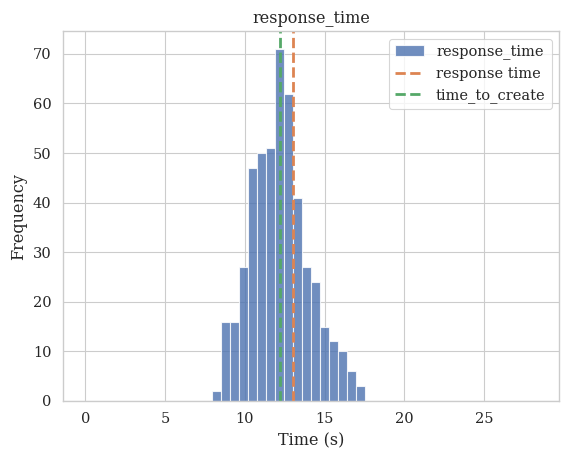

In [61]:
df['time_to_create'] = df['reported_created'] - df['request_start']

x_max = 28.27145886421204

ax = (
    df
    ['time_to_create']
    .plot
    .hist(bins=50, alpha=.8, title=stat, range=(0, x_max), xlabel="Time (s)")
)

ax.axvline(df[stat].mean(), color=palette[1], linestyle='dashed', linewidth=2)
ax.axvline(df['time_to_create'].mean(), color=palette[2], linestyle='dashed', linewidth=2)

ax.legend(['response_time', 'response time', 'time_to_create'])

print(df['time_to_create'].describe())


# Q8: Monthly Trends (total response time)

## Investigate: Successful Requests

In [62]:
data = (
    session.query(
        ImageCreationRequest
    ).filter(
        ImageCreationRequest.success == True,
        ImageCreationRequest.model == 'dalle-3',
    )
)
df = query_to_df(data)
print(len(df))

2331


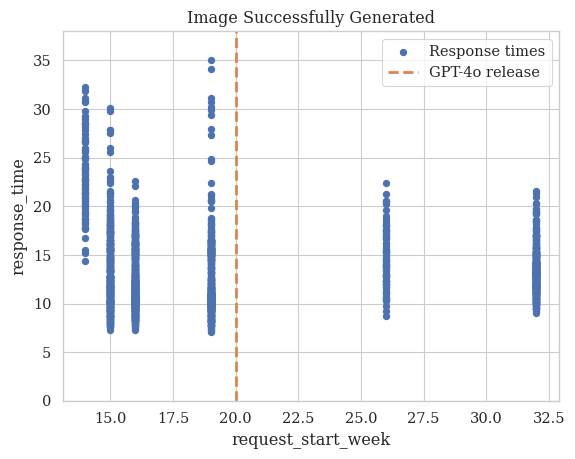

In [63]:
df['request_start_dt'] = pd.to_datetime(df['request_start'], unit='s')
df['request_start_month'] = df['request_start_dt'].dt.month
df['request_start_week'] = df['request_start_dt'].dt.isocalendar().week

# GPT-4o release date (May 13, 2024)
gpt4o_release = datetime(2024, 5, 13)
gpt4o_release_week = gpt4o_release.isocalendar().week

ax = (
    df
    .plot
    .scatter(
        x='request_start_week', y='response_time',
    )
)
ax.axvline(gpt4o_release_week, color=palette[1], linestyle='dashed', linewidth=2)
ax.set_ylim(0, 38)

ax.set_title("Image Successfully Generated")
ax.legend(['Response times', 'GPT-4o release'])

## Investigate: Rejected Requests

In [64]:
data = (
    session.query(
        ImageCreationRequest
    ).filter(
        ImageCreationRequest.success == False,
        ImageCreationRequest.model == 'dalle-3',
    )
)
df = query_to_df(data)
df[:3]

,success,model,request_start,request_end,reported_created,response_time,timing_valid,revised_prompt,status_code,error,revised_prompt_hash,prompt_id,translated_prompt_id,prompt_prefix_id,image_id
id,,,,,,,,,,,,,,,
145,False,dalle-3,1.713344e+09,1.713344e+09,NaN,11.480792,True,None,None,None,None,NaN,229.0,1,None
147,False,dalle-3,1.713344e+09,1.713344e+09,NaN,1.774385,True,None,None,None,None,NaN,231.0,1,None
174,False,dalle-3,1.713438e+09,1.713438e+09,NaN,2.543781,True,None,None,None,None,NaN,846.0,1,None


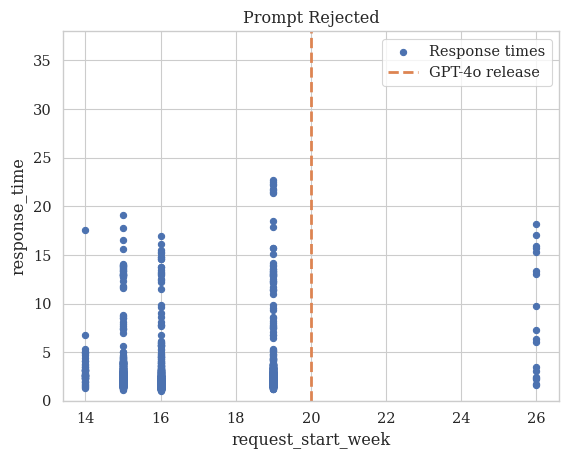

In [65]:
df['request_start_dt'] = pd.to_datetime(df['request_start'], unit='s')
df['request_start_month'] = df['request_start_dt'].dt.month
df['request_start_week'] = df['request_start_dt'].dt.isocalendar().week

# GPT-4o release date (May 13, 2024)
gpt4o_release = datetime(2024, 5, 13)
gpt4o_release_week = gpt4o_release.isocalendar().week

ax = (
    df
    .plot
    .scatter(
        x='request_start_week', y='response_time',
    )
)
ax.axvline(gpt4o_release_week, color=palette[1], linestyle='dashed', linewidth=2)
ax.set_ylim(0, 38)

ax.set_title("Prompt Rejected")
ax.legend(['Response times', 'GPT-4o release'])

# Q9: Rejection Trends

**Goals:** Understand rejection trends since the release of GPT-4o.

In [66]:
data = (
    session.query(
        ImageCreationRequest
    ).filter(
        ImageCreationRequest.success == False,
        ImageCreationRequest.model == 'dalle-3',
        ImageCreationRequest.request_start > gpt4o_release_epoch,
    )
)
df = query_to_df(data)
df[:3]
print(len(df))

18


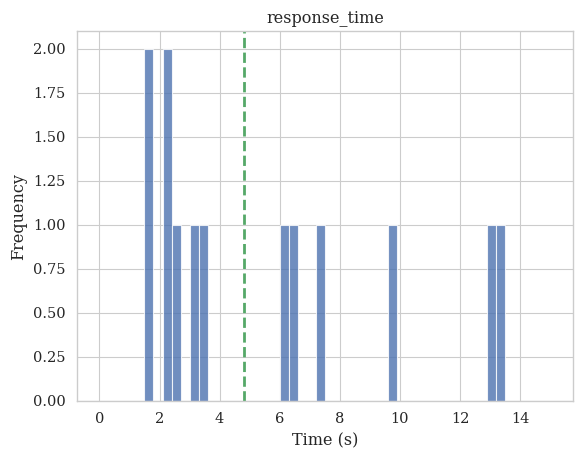

In [67]:
x_max = 15

ax = (
    df
    # .pipe(remove_outliers_iqr, 'response_time')
    ['response_time']
    .plot
    .hist(bins=50, alpha=.8, title='response_time', range=(0, x_max), xlabel="Time (s)")
)

# ax.axvline(df['response_time'].mean(), color=palette[1], linestyle='dashed', linewidth=2)
ax.axvline(4.8, color=palette[2], linestyle='dashed', linewidth=2)

In [68]:
df['response_time'].describe()

count    18.000000
mean      8.601431
std       6.130025
min       1.660761
25%       2.598881
50%       6.804172
75%      14.825223
max      18.141418
Name: response_time, dtype: float64

## Investigate: Isolate Early Rejections

**Goals:** Understand early rejection response time distribution.

In [69]:
data = (
    session.query(
        ImageCreationRequest
    ).filter(
        ImageCreationRequest.success == True,
        ImageCreationRequest.model == 'dalle-3',
    )
)
df = query_to_df(data)

# Find earliest time to create
df['time_to_create'] = df['reported_created'] - df['request_start']
earliest_time_to_create = float(df['time_to_create'].min())
print(f'earliest create: {earliest_time_to_create:.2f} seconds')

data = (
    session.query(
        ImageCreationRequest
    ).filter(
        ImageCreationRequest.success == False,
        ImageCreationRequest.model == 'dalle-3',
        ImageCreationRequest.request_start > gpt4o_release_epoch,
        ImageCreationRequest.response_time < earliest_time_to_create,
    )
)
df = query_to_df(data)
print(len(df))

earliest create: 5.76 seconds
7


<Axes: ylabel='Frequency'>

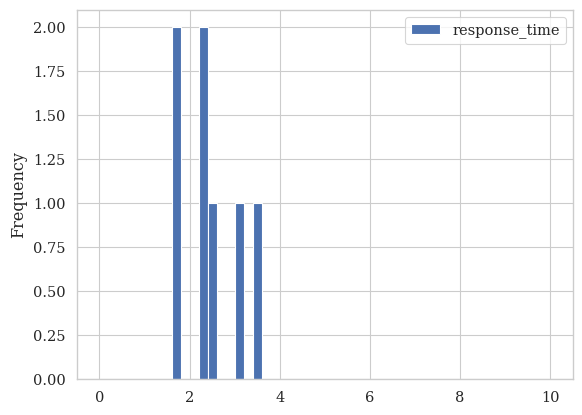

In [70]:
(
    df
    .plot
    .hist(
        y='response_time', range=(0,10), bins=50
    )
)

# DALL-E-2 Blocklist

## Investigate: All Blocklist Rejections

In [71]:
data = (
    session.query(
        ImageCreationRequest.response_time,
        Prompts.dataset,
    ).join(
        Prompts, ImageCreationRequest.prompt_id == Prompts.id
    ).filter(
        or_(
            Prompts.dataset == 'blocklist',
            Prompts.dataset == 'blocklist_mutate',
        )
    )
)
df = query_to_df(data)
len(df)

250

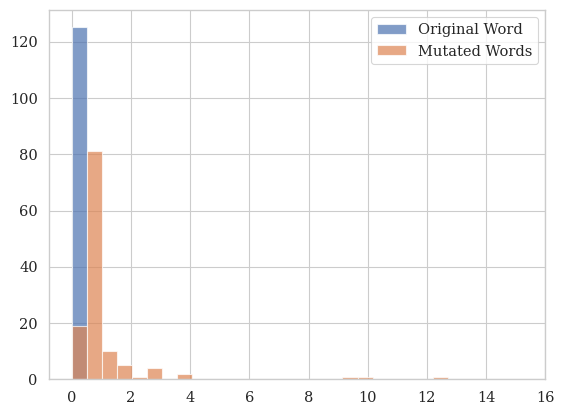

In [72]:
blocklist = df[df['dataset'] == 'blocklist']
blocklist_mutate = df[df['dataset'] == 'blocklist_mutate']

fig, ax = plt.subplots()

plt_range = (0, df['response_time'].max() *1.25)

ax.hist(blocklist['response_time'], range=plt_range, color=palette[0], label="Original Word", alpha=0.7, bins=30)
ax.hist(blocklist_mutate['response_time'], range=plt_range, color=palette[1], label="Mutated Words", alpha=0.7, bins=30)

ax.legend()

plt.show()

## Investigate: Median Response Time Rejection

In [74]:
median_response_time = func.percentile_cont(0.5).within_group(
    ImageCreationRequest.response_time.asc()
).label('median_response_time')

data = (
    session.query(
        median_response_time,
        Prompts.dataset,
        Prompts.prompt,
    ).join(
        Prompts, ImageCreationRequest.prompt_id == Prompts.id
    ).filter(
        or_(
            Prompts.dataset == 'blocklist',
            Prompts.dataset == 'blocklist_mutate',
        )
    ).group_by(
        ImageCreationRequest.prompt_id, Prompts.dataset, Prompts.prompt
    )
)

df = query_to_df(data)
len(df)

50

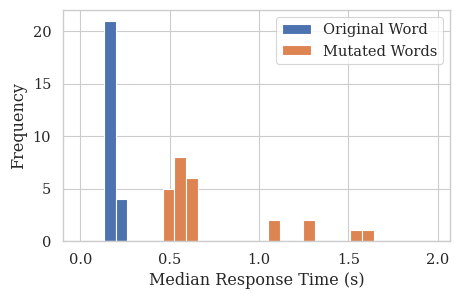

In [81]:
blocklist = df[df['dataset'] == 'blocklist']
blocklist_mutate = df[df['dataset'] == 'blocklist_mutate']

fig, ax = plt.subplots(figsize=(5, 3))

plt_range = (0, df['median_response_time'].max() *1.25)

ax.hist(blocklist['median_response_time'], range=plt_range, color=palette[0], label="Original Word", bins=30)
ax.hist(blocklist_mutate['median_response_time'], range=plt_range, color=palette[1], label="Mutated Words", bins=30)

ax.legend()

ax.set_ylabel('Frequency')
ax.set_xlabel('Median Response Time (s)')

plt.show()

In [82]:
df[df['median_response_time'] < 0.5]

,median_response_time,dataset,prompt
0,0.183459,blocklist,None
2,0.184361,blocklist,None
4,0.201148,blocklist,None
5,0.203663,blocklist,None
6,0.200196,blocklist,None
7,0.173052,blocklist,None
8,0.195037,blocklist,None
9,0.197539,blocklist,None
16,0.154946,blocklist,None
17,0.171868,blocklist,None


In [83]:
df[df['median_response_time'] >= 0.5]

,median_response_time,dataset,prompt
1,0.512995,blocklist_mutate,None
3,0.523655,blocklist_mutate,None
10,0.556883,blocklist_mutate,None
11,1.089107,blocklist_mutate,None
12,1.084298,blocklist_mutate,None
13,1.577459,blocklist_mutate,None
14,1.269013,blocklist_mutate,None
15,0.605021,blocklist_mutate,None
30,0.526150,blocklist_mutate,None
31,0.530708,blocklist_mutate,None
